# Impact of introducing MMR vaccine into the mandatory vaccination schedule on the incidence of mumps and rubella in CABA.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [1]:
import warnings; warnings.simplefilter('ignore')

## 2. Pre-analysis

### 2.1 Visualizing yearly incidence of vaccine-preventable diseases over time

In [20]:
mask = ['parotiditis', 'rubeola']
vaccine_pd = (pd.read_csv('../datasets/vaccine-preventable-diseases.csv')
                 .set_index('year', drop=True)
                 .loc[:, mask]
                 .assign(viral_total = lambda df: df['parotiditis'] + df['rubeola']))

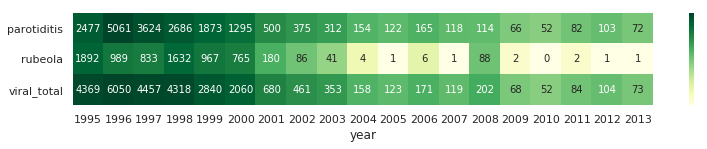

In [25]:
fig, ax = plt.subplots(1,1,figsize=(13,1.7))
sns.heatmap(np.log(vaccine_pd.T+0.1), robust=True, annot=vaccine_pd.T, fmt="d",
            cmap='YlGn', ax = ax, cbar_kws={'ticks':[]}); plt.show()

### 2.2 Visualizing yearly MMR vaccination numbers

In [16]:
mask = ['antirrubeolica', 'antiparotiditis', 'doble_viral','triple_viral']
vaccine_records = (pd.read_csv('../datasets/vaccination-records.csv')
                       .set_index('year', drop=True)
                       .loc[:, mask]
                       .assign(viral_total = lambda x: x.sum(axis=1)))

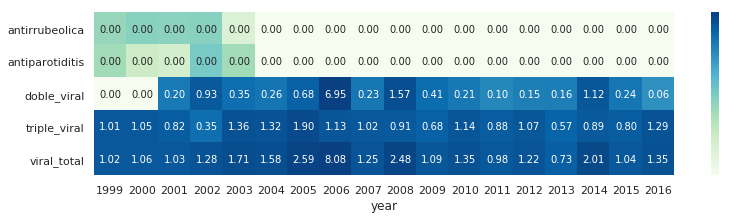

In [23]:
fig, ax = plt.subplots(1,1,figsize=(13,3))
sns.heatmap(np.log(vaccine_records.T+0.1), robust=True, annot=np.divide(vaccine_records.T,100_000),
            fmt=".2f", cmap='GnBu', ax = ax, cbar_kws={'ticks':[]}); plt.show()

### 2.3 Setting the DataFrame for analysis

In [40]:
data = (pd.DataFrame({'year': range(1995,2013)})
            .merge(vaccine_pd['viral_total'].reset_index(), on='year', how='left')
            .rename(columns={'viral_total':'cases'})
            .set_index('year')
       )

## 3. Analysis

In [39]:
import pymc3 as pm

In [ ]:
with pm.Model() as model:
    alpha = 1.0/data.cases.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau",lower=0, upper=data.cases.size - 1)
    
    idx = np.arange(data.cases.size)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=data.cases)
    difference = pm.Deterministic('difference', lambda_1 - lambda_2)
    
    step = pm.Metropolis()
    start = pm.find_MAP()
    trace = pm.sample(10000, step=step, start=start, progressbar=True)

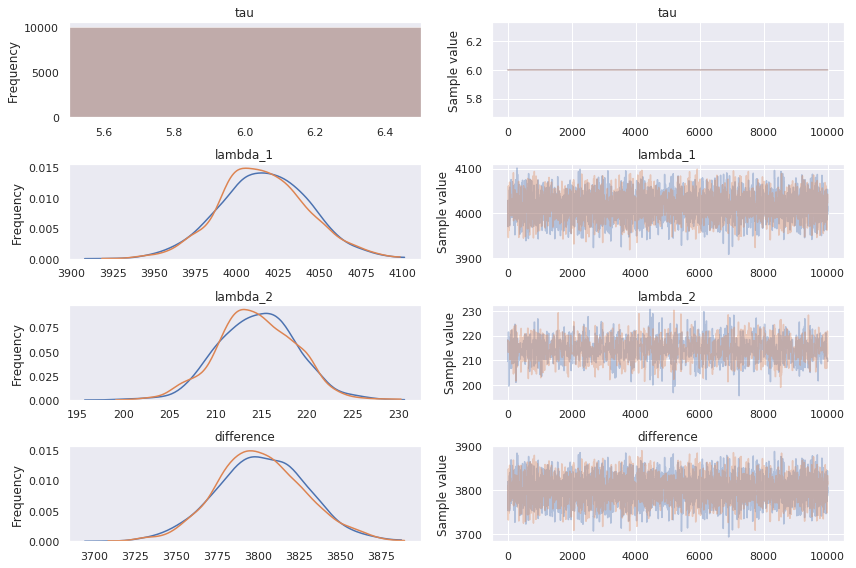

In [44]:
pm.traceplot(trace)
plt.show()

In [46]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
tau,6.000000,0.000000,0.000000,6.000000,6.000000,NaN,NaN
lambda_1,4016.390892,26.589245,0.442559,3965.842514,4071.496671,3304.025507,1.000228
lambda_2,214.565753,4.195638,0.093671,206.406490,222.423427,1648.506811,1.000210
difference,3801.825140,26.907858,0.456825,3751.551683,3857.688410,3253.771753,1.000145
